In [1]:
# Importing Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    mean_squared_error, accuracy_score,
    ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

In [2]:
# Load and Clean the Data
players_df = pd.read_csv('./datasets/players.csv')
team_df = pd.read_csv('./datasets/team.csv')

# Automatically handle 'Unnamed' columns
players_df.rename(columns=lambda x: x if not x.startswith('Unnamed') else f'Col_{x.split(":")[-1]}', inplace=True)
team_df.rename(columns=lambda x: x if not x.startswith('Unnamed') else f'Col_{x.split(":")[-1]}', inplace=True)

In [3]:
# Remove columns with all missing values
players_cleaned = players_df.dropna(axis=1, how='all')
team_cleaned = team_df.dropna(axis=1, how='all')

# Check and handle duplicates
players_cleaned.drop_duplicates(inplace=True)
team_cleaned.drop_duplicates(inplace=True)

# Descriptive Statistics
print("Players Dataset Statistics:")
print(players_cleaned.describe())

print("\nTeams Dataset Statistics:")
print(team_cleaned.describe())

Players Dataset Statistics:
           Col_ 0         Age          GP           W           L         Min  \
count  488.000000  488.000000  488.000000  488.000000  488.000000  488.000000   
mean   243.745902   25.811475   13.077869    6.518443    6.559426   19.068852   
std    140.090573    4.317639    6.205754    4.281624    4.097948   10.611536   
min      1.000000   18.000000    1.000000    0.000000    0.000000    1.200000   
25%    122.250000   23.000000    7.750000    3.000000    3.000000    9.275000   
50%    244.500000   25.000000   15.000000    6.000000    7.000000   19.000000   
75%    364.000000   28.000000   19.000000   10.000000    9.000000   28.300000   
max    472.000000   39.000000   22.000000   17.000000   16.000000   38.100000   

              PTS         FGM         FGA         FG%  ...         REB  \
count  488.000000  488.000000  488.000000  488.000000  ...  488.000000   
mean     8.787705    3.197131    6.959836   44.390779  ...    3.517008   
std      7.113701   

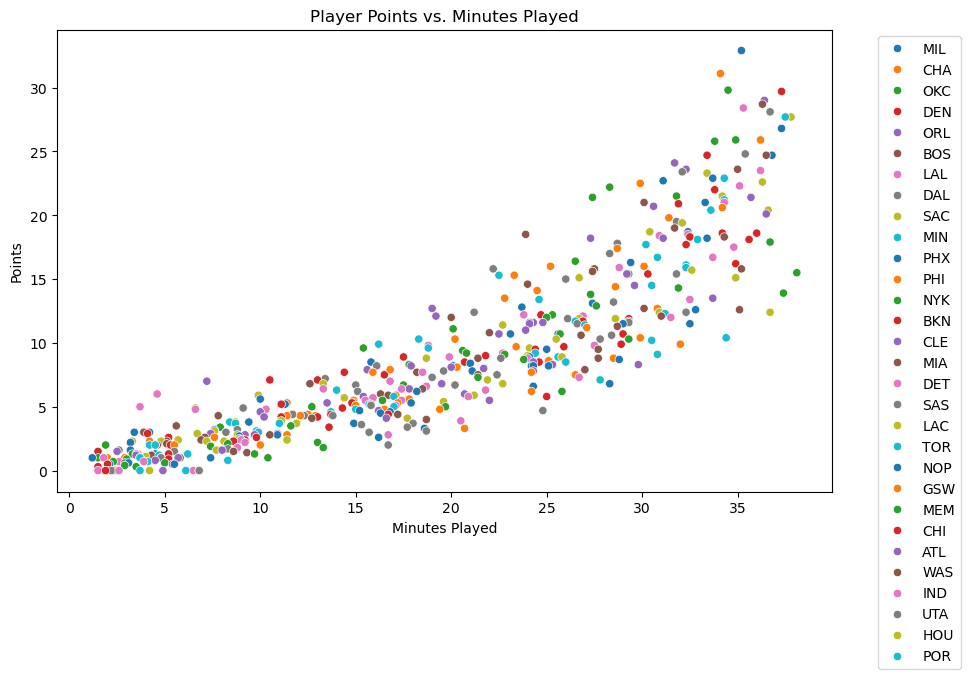

In [4]:
# Visualization: Points vs. Minutes Played (From players_cleaned)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=players_cleaned, x='Min', y='PTS', hue='Team', palette='tab10')
plt.title('Player Points vs. Minutes Played')
plt.xlabel('Minutes Played')
plt.ylabel('Points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [5]:
# Add Efficiency and Player Efficiency Rating (PER)
players_cleaned['Efficiency'] = players_cleaned['PTS'] / players_cleaned['Min']
players_cleaned['Efficiency'] = players_cleaned['Efficiency'].fillna(0)

# PER calculation 
players_cleaned['PER'] = (
                                 players_cleaned['PTS'] + players_cleaned['REB'] +
                                 players_cleaned['AST'] + players_cleaned['STL'] + players_cleaned['BLK']
                         ) - players_cleaned['TOV']

In [6]:
# Feature Engineering: Team-Level Efficiency and Performance Classification
team_cleaned['Efficiency'] = (
                                     team_cleaned['PTS'] + team_cleaned['REB'] + team_cleaned['AST'] +
                                     team_cleaned['STL'] + team_cleaned['BLK'] - team_cleaned['TOV']
                             ) / team_cleaned.shape[0]  

# Classify teams based on their efficiency
team_cleaned['Performance'] = pd.cut(
    team_cleaned['Efficiency'],
    bins=[-np.inf, 0.5, 1.0, np.inf],  
    labels=['Bad', 'Average', 'Good']
)

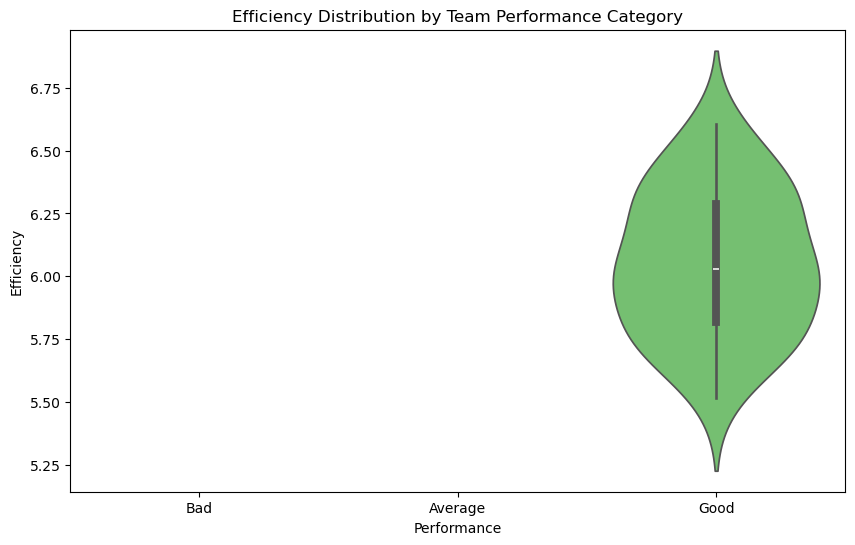

In [7]:
# Visualization: Team Performance Categories (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(data=team_cleaned, x='Performance', y='Efficiency', palette='muted')
plt.title('Efficiency Distribution by Team Performance Category')
plt.show()

In [9]:
# Model Training Data Preparation for Regression (from players_cleaned)
X_reg = players_cleaned[['Min', 'REB', 'AST', 'STL', 'BLK', 'TOV']].fillna(0)
y_reg = players_cleaned['Efficiency']

X_class = X_reg
y_class = y_reg

In [10]:
# Split data for regression and classification
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2,
                                                                            random_state=42)
# Regression: Ridge Model with Cross-Validation
ridge = Ridge(alpha=1.0)
ridge_cv = cross_val_score(ridge, X_reg, y_reg, cv=KFold(n_splits=5))
ridge.fit(X_reg_train, y_reg_train)
y_reg_pred = ridge.predict(X_reg_test)

In [11]:
# Permutation Feature Importance for Regression
perm_importance_reg = permutation_importance(ridge, X_reg_test, y_reg_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_reg.columns,
    'Importance': perm_importance_reg.importances_mean
}).sort_values(by='Importance', ascending=False)

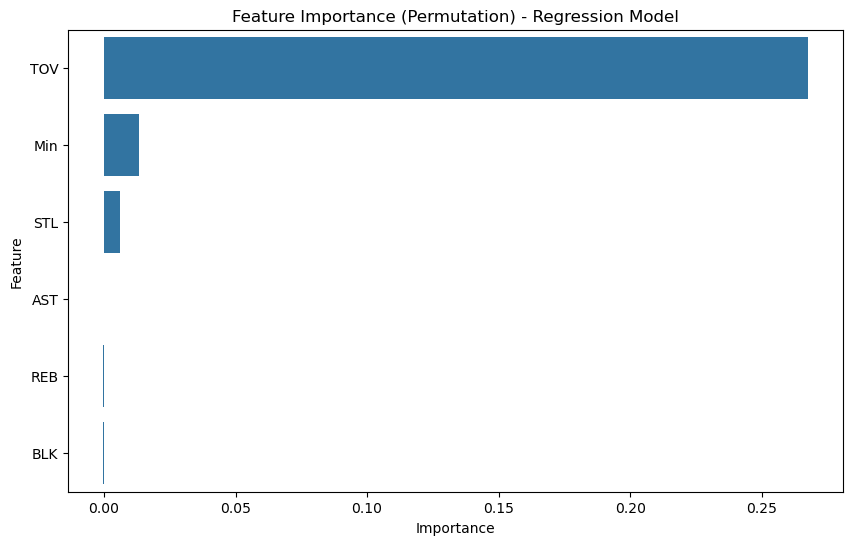

In [12]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Permutation) - Regression Model')
plt.show()

In [13]:
# Determine Threshold and Drop Unimportant Features (Regression)
importance_threshold = 0.01 

In [14]:
# Filter regression features
important_features_reg = importance_df[importance_df['Importance'] > importance_threshold]['Feature'].tolist()
X_reg_filtered = X_reg[important_features_reg]

# Re-split data with filtered features
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg_filtered, y_reg, test_size=0.2,
                                                                    random_state=42)

# Regression Evaluation
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
print("Regression Model Evaluation:")
print(f"Cross-Validation Score: {ridge_cv.mean():.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Save Ridge Model
with open('./models/ridge_model.pkl', 'wb') as file:
    pickle.dump(ridge, file)

Regression Model Evaluation:
Cross-Validation Score: -1.1676
Root Mean Squared Error (RMSE): 0.2101


In [15]:
# Classification: Logistic Regression with Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=KFold(n_splits=5), scoring='accuracy')
grid.fit(X_class_train, y_class_train)

classifier = grid.best_estimator_
y_class_pred = classifier.predict(X_class_test)
y_class_proba = classifier.predict_proba(X_class_test)

ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\GenAi\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\GenAi\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\User\anaconda3\envs\GenAi\lib\site-packages\sklearn\linear_model\_logistic.py", line 1231, in fit
    check_classification_targets(y)
  File "C:\Users\User\anaconda3\envs\GenAi\lib\site-packages\sklearn\utils\multiclass.py", line 219, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [16]:
# Permutation Feature Importance for Classification
perm_importance_class = permutation_importance(classifier, X_class_test, y_class_test, n_repeats=10, random_state=42)
class_importance_df = pd.DataFrame({
    'Feature': X_class.columns,
    'Importance': perm_importance_class.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=class_importance_df)
plt.title('Feature Importance (Permutation) - Classification Model')
plt.show()

NameError: name 'classifier' is not defined

In [ ]:
# Determine Threshold and Drop Unimportant Features (Classification)
important_features_class = class_importance_df[class_importance_df['Importance'] > importance_threshold][
    'Feature'].tolist()
X_class_filtered = X_class[important_features_class]

In [ ]:
# Re-split data with filtered features
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class_filtered, y_class, test_size=0.2,
                                                                            random_state=42)

# For one-hot encoded arrays
if len(y_class_test.shape) > 1:
    y_class_test = np.argmax(y_class_test, axis=1)

if len(y_class_pred.shape) > 1:
    y_class_pred = np.argmax(y_class_pred, axis=1)

In [ ]:
# Classification Evaluation
accuracy = accuracy_score(y_class_test, y_class_pred)
precision = precision_score(y_class_test, y_class_pred, average='weighted')
recall = recall_score(y_class_test, y_class_pred, average='weighted')
f1 = f1_score(y_class_test, y_class_pred, average='weighted')

In [ ]:
roc_auc = roc_auc_score(y_class_test, y_class_proba, multi_class='ovr')
# Print the evaluation metrics
print("\nClassification Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Save Logistic Model
with open('./models/logistic_model.pkl', 'wb') as file:
    pickle.dump(classifier, file)

In [ ]:
# Visualization: Violin Plot for Performance Categories (from team_cleaned)
plt.figure(figsize=(10, 6))
sns.violinplot(data=team_cleaned, x='Performance', y='Efficiency', palette='muted')
plt.title('Efficiency Distribution by Team Performance Category')
plt.show()